In [9]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Load data
train_data = pd.read_csv("train.csv")
train_extra_data = pd.read_csv("training_extra.csv")
test_data = pd.read_csv("test.csv")

In [6]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB
None


In [5]:
print(train_extra_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694318 entries, 0 to 3694317
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Brand                 object 
 2   Material              object 
 3   Size                  object 
 4   Compartments          float64
 5   Laptop Compartment    object 
 6   Waterproof            object 
 7   Style                 object 
 8   Color                 object 
 9   Weight Capacity (kg)  float64
 10  Price                 float64
dtypes: float64(3), int64(1), object(7)
memory usage: 310.0+ MB
None


In [7]:
train_data.sample(10)

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
212638,212638,Puma,Leather,Medium,5.0,No,Yes,Tote,Blue,8.834231,107.72363
57778,57778,Under Armour,Nylon,Large,4.0,Yes,No,Messenger,Pink,21.442366,109.40532
260839,260839,Nike,Leather,Medium,4.0,Yes,No,Tote,Green,11.317500,114.06716
31819,31819,Adidas,Leather,Medium,4.0,Yes,Yes,Tote,Green,21.205033,111.75664
100004,100004,Jansport,Polyester,Large,3.0,Yes,Yes,NaN,Pink,15.509250,111.64697
170459,170459,Nike,Canvas,Medium,4.0,Yes,Yes,Tote,Pink,8.448964,37.20815
126818,126818,Under Armour,Leather,Small,9.0,No,NaN,Backpack,Gray,20.099507,50.54738
182137,182137,Jansport,Leather,Small,5.0,Yes,Yes,Tote,Red,10.282485,108.68969
284554,284554,Nike,Canvas,Small,5.0,No,No,NaN,Gray,26.277727,25.70444
142667,142667,Puma,Polyester,Large,9.0,No,No,Backpack,Blue,23.158232,56.69304


Text(0.5, 1.0, 'Price Dist.')

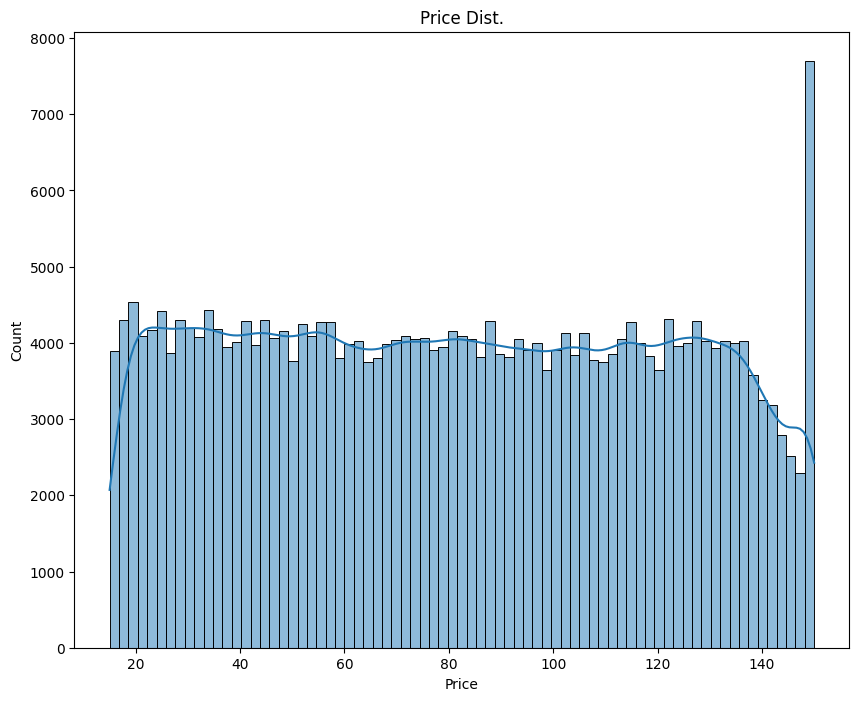

In [13]:
plt.figure(figsize=(10, 8))
sns.histplot(train_data["Price"], bins=75, kde=True)
plt.title("Price Dist.")

Lots of backpacks at $150 for some reason.

**Data cleaning time:** 

Since there are lots of features with missing categorical values, I will first try to impute them using K-nearest neighbors. If this doesn't seem to yield great results later, I will come back and try different methods for the missing data.

In [17]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

copy_train_data = train_data.copy()

# Fill missing numerical values with the mean
numer_cols = ["Weight Capacity (kg)"] # only numerical feature with missing data
for col in numer_cols:
    copy_train_data[col].fillna(copy_train_data[col].mean(), inplace=True)

# Convert categorical columns into numeric form for KNN
categ_cols = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
label_encoders = {}

for col in categ_cols:
    le = LabelEncoder()
    # convert to string for label encoding
    copy_train_data[col] = copy_train_data[col].astype(str)
    # encode catergorical values
    copy_train_data[col] = le.fit_transform(copy_train_data[col])
    #store encoder for decoding later
    label_encoders[col] = le

knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
copy_train_data[categ_cols] = knn_imputer.fit_transform(copy_train_data[categ_cols])

# Convert categorical values back to original labels
for col in categ_cols:
    copy_train_data[col] = copy_train_data[col].astype(int)
    copy_train_data[col] = label_encoders[col].inverse_transform(copy_train_data[col])

C:\Users\ellio\AppData\Local\Temp\ipykernel_32276\2163509324.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  copy_train_data[col].fillna(copy_train_data[col].mean(), inplace=True)


In [18]:
copy_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 300000 non-null  object 
 2   Material              300000 non-null  object 
 3   Size                  300000 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    300000 non-null  object 
 6   Waterproof            300000 non-null  object 
 7   Style                 300000 non-null  object 
 8   Color                 300000 non-null  object 
 9   Weight Capacity (kg)  300000 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB
